# Influence metric computation
In this notebook, we carry out a t-test in order to assess the variation of the baby naming at the release of a movie.

In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from scipy import stats

## 1. Methodology

The computation is made as follows. First, we pick the 10 datapoints (10 years) before the movie release and we compute the difference between adjacent values to get the variation . It is done as follows :

`difference = datapoints[1:] - datapoints[:-1]`

Then we do the same for the 5 datapoints after the movie release. Finally a t-test is carried out between the two difference arrays.
We keep the p-value which will tell us if the variation at the movie release is significant or not and the t-statistic which will indicate if the variation is positive or negative. We decided to chose a signifiance level of 0.1

We first carry the computation on a single movie and a single name to be able to plot the data with regression lines to validate the methodology visually.

The regression is then carried out for each of the character name in the name_by_movie_ordered_df dataframe by adding a column for the t-statistic value and the p-value.

## 2. Import processed data

We need three dataframes present in the preprocessed folder.
1. `movie_df` : to have the release date
2. `name_by_movie_ordered_df` : to have the character name and their corresponding movies. The p-value and t-statistic will be added there.
3. `baby_name_df` : to have the data on the baby name

In [ ]:
folder_processed_data_path = './data/processed_data/'

# import movie_df to get the release date
movie_df = pd.read_csv(os.path.join(folder_processed_data_path, 'movie_df.csv'))
movie_df.set_index(['wiki_ID'], inplace=True)

# import name_by_movie_ordered_df to get the character name and their corresponding movies. 
name_by_movie_ordered_df = pd.read_csv(os.path.join(folder_processed_data_path, 'name_by_movie_ordered_df.csv'))

baby_name_df = pd.read_csv(os.path.join(folder_processed_data_path, 'baby_name_df.csv'))

print("movie_df :")
display(movie_df.head())
print("name_by_movie_ordered_df :")
display(name_by_movie_ordered_df.head())
print("baby_name_df :")
display(baby_name_df.head())

movie_df :


,mov_name,year,month,revenue,numVotes,averageRating,poster_url,IMDB_ID
wiki_ID,,,,,,,,
975900,Ghosts of Mars,2001,8.0,14010832.0,56880,4.9,/9SdsZUF4c6JC4D7BaS6q4atglJ5.jpg,tt0228333
3196793,Getting Away with Murder: The JonBenét Ramsey ...,2000,2.0,NaN,69,6.0,NaN,tt0245916
28463795,Brun bitter,1988,NaN,NaN,40,5.6,NaN,tt0094806
9363483,White Of The Eye,1987,NaN,NaN,2891,6.1,NaN,tt0094320
261236,A Woman in Flames,1983,NaN,NaN,623,5.9,NaN,tt0083949


name_by_movie_ordered_df :


,wiki_ID,char_words,order,gender
0,3217,Gold,6.0,NaN
1,3217,Linda,7.0,F
2,3217,Henry,4.0,M
3,3217,Duke,4.0,M
4,3217,Warrior,9.0,M


baby_name_df :


,name,year,number,percentage
0,Aaban,2007,1,0.000026
1,Aadam,2007,4,0.000103
2,Aadan,2007,4,0.000103
3,Aadarsh,2007,9,0.000233
4,Aaden,2007,153,0.003957


In [3]:
# In baby_name_df, add zero percentage data point for the years where there are no data
max_year = baby_name_df['year'].max()
min_year = baby_name_df['year'].min()
print("max_year : ", max_year)
print("min_year : ", min_year)

max_year :  2022
min_year :  1880


In [4]:
# Create a reference DataFrame with all combinations of 'name' and 'year'
all_names = baby_name_df['name'].unique()
all_years = range(1880, 2022)

reference_df = pd.DataFrame([(name, year) for name in all_names for year in all_years],
                             columns=['name', 'year'])

# Merge the reference DataFrame with the original DataFrame
zero_padding_baby_name_df = pd.merge(reference_df, baby_name_df, on=['name', 'year'], how='left').copy(deep=True)

# Replace NaN values with 0 in both score columns
zero_padding_baby_name_df['number'] = zero_padding_baby_name_df['number'].fillna(0)
zero_padding_baby_name_df['percentage'] = zero_padding_baby_name_df['percentage'].fillna(0)

# Display the result
display(zero_padding_baby_name_df)
print(f"Length of baby_name_df : {len(baby_name_df)}")
print(f"Length of zero_padding_baby_name_df : {len(zero_padding_baby_name_df)}")

,name,year,number,percentage
0,Aaban,1880,0.0,0.0
1,Aaban,1881,0.0,0.0
2,Aaban,1882,0.0,0.0
3,Aaban,1883,0.0,0.0
4,Aaban,1884,0.0,0.0
...,...,...,...,...
14547753,Zeljko,2017,0.0,0.0
14547754,Zeljko,2018,0.0,0.0
14547755,Zeljko,2019,0.0,0.0
14547756,Zeljko,2020,0.0,0.0


Length of baby_name_df : 1903290
Length of zero_padding_baby_name_df : 14547758


In [5]:
baby_name_df = zero_padding_baby_name_df.copy(deep=True)

## 3. Testing computation on a single movie, one character name
### 3.1 Data setup
Let's choose the famous movie "Pulp Fiction" and the character `Mia`

In [6]:
nb_year_after = 5
nb_year_before = 10

In [7]:
# search the movie ID
chosen_movie_name = "Pulp Fiction"
movie_df.query("mov_name == @chosen_movie_name")

,mov_name,year,month,revenue,numVotes,averageRating,poster_url,IMDB_ID
wiki_ID,,,,,,,,
54173,Pulp Fiction,1994,5.0,213928762.0,2158972,8.9,/on5fMsjLKMJX6ic4anPKwVnuExu.jpg,tt0110912


In [8]:
chosen_name = 'Mia'
chosen_movie_ID = 54173

print(f"The chosen character is {chosen_name} in the movie \"{movie_df.loc[chosen_movie_ID]['mov_name']}\" released in {movie_df.loc[chosen_movie_ID]['year']}")

In [9]:
# filter the baby name dataframe to get only the data of "Mia" baby name
chosen_baby_name_df = baby_name_df.query("name == @chosen_name").sort_values(by=['year'])

In [10]:
# get the release date
release_year = movie_df.loc[chosen_movie_ID]['year']
print(f"release year = {release_year}")

We select the range of years before and after the movie release coresponding to the baby name data, with the corresponding percentage of babies with this name:

In [11]:
before_df = chosen_baby_name_df[(chosen_baby_name_df.year >= release_year-nb_year_before) & (chosen_baby_name_df.year <= release_year-1)].reset_index()
after_df = chosen_baby_name_df[(chosen_baby_name_df.year >= release_year) & (chosen_baby_name_df.year <= release_year+nb_year_after-1)].reset_index()
display(before_df)
display(after_df)

,index,name,year,number,percentage
0,3121832,Mia,1984,448.0,0.013108
1,3121833,Mia,1985,496.0,0.014188
2,3121834,Mia,1986,487.0,0.013987
3,3121835,Mia,1987,545.0,0.015450
4,3121836,Mia,1988,616.0,0.017049
5,3121837,Mia,1989,672.0,0.017883
6,3121838,Mia,1990,779.0,0.020174
7,3121839,Mia,1991,775.0,0.020380
8,3121840,Mia,1992,818.0,0.021828
9,3121841,Mia,1993,796.0,0.021660


,index,name,year,number,percentage
0,3121842,Mia,1994,857.0,0.023661
1,3121843,Mia,1995,1098.0,0.030791
2,3121844,Mia,1996,1686.0,0.047497
3,3121845,Mia,1997,2491.0,0.070647
4,3121846,Mia,1998,2562.0,0.071663


Let's plot the curve and highlight the release date.

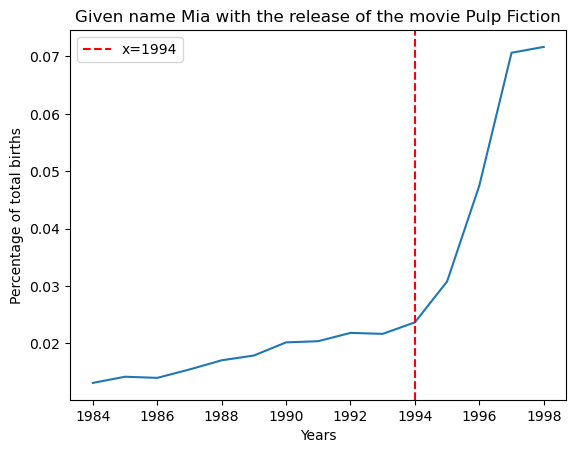

In [12]:
union_before_after_df = pd.concat([before_df, after_df], ignore_index=True)

x_values = union_before_after_df['year'].values
y_values = union_before_after_df['percentage'].values

# Create a scatter plot
plt.plot(x_values, y_values)
plt.xlabel('Years')
plt.ylabel('Percentage of total births')
plt.title(f'Given name {chosen_name} with the release of the movie {movie_df.loc[chosen_movie_ID].mov_name}')

# Draw vertical lines for each movie release
plt.axvline(x=release_year, color='r', linestyle='--', label=f'x={release_year}')
plt.legend()

plt.show()

### 3.2 Compute regression
Lets now carry out a linear regression on both side of the release date.

In [13]:
# model before release
mod_before = smf.ols(formula = 'percentage ~ year' , data = before_df)
np.random.seed(2)
res_before = mod_before.fit()

coefficients_before = res_before.params.values
beta_before = coefficients_before[1]
intercept_before = coefficients_before[0]

# model after release
mod_after = smf.ols(formula = 'percentage ~ year' , data = after_df)
res_after = mod_after.fit()

coefficients_after = res_after.params.values
beta_after = coefficients_after[1]
intercept_after = coefficients_after[0]

print("Before release : ")
print(f"   beta = {beta_before:.4f}, intercept = {intercept_before:.2f} \n")

print("After release : ")
print(f"   beta = {beta_after:.4f}, intercept = {intercept_after:.2f}")

Before release : 
   beta = 0.0011, intercept = -2.12 

After release : 
   beta = 0.0136, intercept = -27.07


And plot the regression lines.

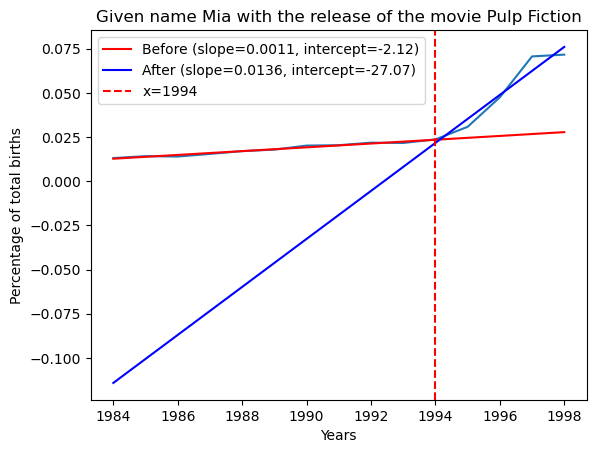

In [14]:
union_before_after_df = pd.concat([before_df, after_df], ignore_index=True)

x_values = union_before_after_df['year'].values
y_values = union_before_after_df['percentage'].values

# Create a scatter plot
plt.plot(x_values, y_values)
plt.xlabel('Years')
plt.ylabel('Percentage of total births')
plt.title(f'Given name {chosen_name} with the release of the movie {movie_df.loc[chosen_movie_ID].mov_name}')

# Calculate y values for the regression lines
reg_before = beta_before * x_values + intercept_before
reg_after = beta_after * x_values + intercept_after
# Plot the regression lines
plt.plot(x_values, reg_before, label=f'Before (slope={beta_before:.4f}, intercept={intercept_before:.2f})', color='red')
plt.plot(x_values, reg_after, label=f'After (slope={beta_after:.4f}, intercept={intercept_after:.2f})', color='blue')

# Draw vertical lines for each movie release
plt.axvline(x=release_year, color='r', linestyle='--', label=f'x={release_year}')
plt.legend()

plt.show()

### 3.3 T-test
Now we carry out a t-test on the two regression lines.

In [15]:
before_diffs = before_df['percentage'][1:].values - before_df['percentage'][:-1]
after_diffs = after_df['percentage'][1:].values - after_df['percentage'][:-1]

# Comparing the slopes of the two regression models
t_stat, p_value = stats.ttest_ind(before_diffs, after_diffs)

print("T-statistic:", t_stat)
print("P-value:",p_value)
print("Slope change:",after_diffs.mean()-before_diffs.mean())


T-statistic: -3.5405099407316394
P-value: 0.0046285686243801175
Slope change: 0.011050212658611263


We have a p-value lower than 0.1, therefore the variation is signification with our significance level. The t-statistic shows that it is an increase.

## 4. Computation for all movie and character
Here the same computation is done for all characters of all movie using the apply method on the dataframe name_by_movie.

The computation is time-consuming (25min). Therefore the output is not there.

In [ ]:
iter = 0

nb_yr_before = 10
nb_yr_after = 5

# Function to calculate total income (salary + bonus)
def apply_regression(row):
    global iter

    chosen_movie_ID = row['wiki_ID']
    chosen_name = row['char_words']
    
    chosen_baby_name_df = baby_name_df.query("name == @chosen_name").sort_values(by=['year'])

    release_year = movie_df.loc[chosen_movie_ID]['year']
    
    before_df = chosen_baby_name_df[(chosen_baby_name_df.year >= release_year-nb_year_before) & (chosen_baby_name_df.year <= release_year-1)].reset_index()
    after_df = chosen_baby_name_df[(chosen_baby_name_df.year >= release_year) & (chosen_baby_name_df.year <= release_year+nb_year_after-1)].reset_index()
    
    if (len(before_df) != nb_yr_before) or (len(after_df) != nb_yr_after):
        # print("not enough datapoints : return NaN")
        row['t_stat'] = np.NaN
        row['p_value'] = np.NaN
        row['slope_change'] = np.NaN
    else:
        before_diffs = before_df['percentage'][1:].values - before_df['percentage'][:-1]
        after_diffs = after_df['percentage'][1:].values - after_df['percentage'][:-1]

        # Comparing the slopes of the two regression models
        t_stat, p_value = stats.ttest_ind(before_diffs, after_diffs)

        row['t_stat'] = t_stat
        row['p_value'] = p_value
        row['slope_change'] = after_diffs.mean() - before_diffs.mean()

    iter += 1
    print("Batch {} of {}".format(iter, len(name_by_movie_ordered_df)), end="\r")
    
    # print(f"Movie ID : {chosen_movie_ID}, Name : {chosen_name}, P-VALUE = {p_value}")
    # print(f"Movie ID : {chosen_movie_ID}, Name : {chosen_name}, slope change = {row['slope_change']}, t-stat = {row['t_stat']}")
    return row

# Apply the function to the dataframe
name_by_movie_ordered_pvalue_df = name_by_movie_ordered_df.copy(deep=True)
name_by_movie_ordered_pvalue_df = name_by_movie_ordered_pvalue_df.apply(apply_regression, axis=1)

display(name_by_movie_ordered_pvalue_df.head())

Export the new name_by_movie dataframe with the result of the t-test.

In [ ]:
processed_folder = './data/processed_data/'
name_by_movie_ordered_pvalue_df.to_csv(os.path.join(processed_folder, 'name_by_movie_ordered_pvalue_10_5_test1.csv'), index=False)

In [ ]:
# compute the percentage of missing values in p_value column
print(f"Percentage of missing values in p_value column : {name_by_movie_ordered_pvalue_df['p_value'].isna().sum()/len(name_by_movie_ordered_pvalue_df)*100:.2f}%")

## 5. Results

In [16]:
name_by_movie = pd.read_csv(os.path.join(folder_processed_data_path, 'name_by_movie_ordered_pvalue_10_5_df.csv'))

In [17]:
# compute the percentage of missing values in p_value column
print(f"Percentage of missing values in p_value column : {name_by_movie['p_value'].isna().sum()/len(name_by_movie)*100:.2f}%")

Percentage of missing values in p_value column : 12.73%


Now lets see how many of the movie character have a significant impact.

In [18]:
significant_names = len(name_by_movie[name_by_movie['p_value'] <= 0.1])/len(name_by_movie)
print(f"Proportion of significant character name : {significant_names*100:.2f}%")

Proportion of significant character name : 14.30%


From our analysis, we get that 14.30% of the names have a significant variation after the movie release.

In [19]:
not_significant_names = len(name_by_movie[name_by_movie['p_value'] >= 0.1])/len(name_by_movie)
print(f"Proportion of non significant character name : {not_significant_names*100:.2f}%")

Proportion of non significant character name : 72.98%


In [20]:
nan_p_values = len(name_by_movie[name_by_movie['p_value'].isna()])/len(name_by_movie)
print(f"Proportion of non calculated character name : {nan_p_values*100:.2f}%")

Proportion of non calculated character name : 12.73%


The last proportion concerns the case where there were missing baby name data in the area of the movie release to carry out the t-test.

In [21]:
nb_movie_significant = len(name_by_movie[name_by_movie['p_value'] <= 0.1]['wiki_ID'].unique())
print(f"The number of movie that have a significiant variation in one of its character name given to baby is : {nb_movie_significant}")

The number of movie that have a significiant variation in one of its character name given to baby is : 12669


In [22]:
percent_movie_significant = (nb_movie_significant / len(movie_df))*100
print(f"Therefore, {percent_movie_significant:.2f}% of the movies have one of its characters that shows to have caused a variation on baby naming at the movie release.")

Therefore, 19.34% of the movies have one of its characters that shows to have caused a variation on baby naming at the movie release.
